In [154]:
%matplotlib inline
import numpy as np

In [155]:
def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8)

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28)).astype(np.float32) / 255
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[16:].reshape((-1, 28, 28)).astype(np.float32) / 255
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import tensor
from tqdm import trange
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [171]:
class SmolNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(28 * 28, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.log_softmax(self.l2(x), dim=1)
        return x

model = SmolNet()

loss=0.61, acc=0.906250: 100%|██████████| 1000/1000 [00:01<00:00, 590.92it/s]


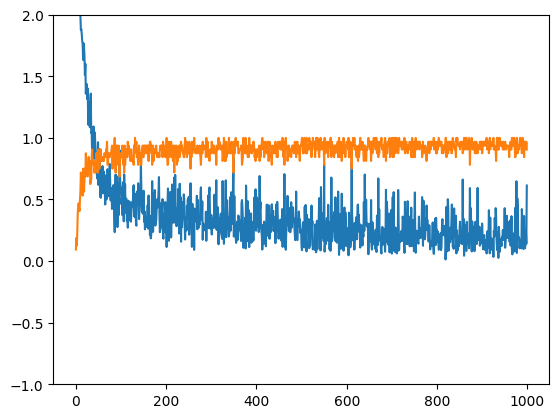

In [172]:
# train
BATCH = 32
loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())
accuracies = []
losses = []
for i in (t := trange(1000)):
    # prepare data
    samp = np.random.randint(0, X_train.shape[0], size=(BATCH))
    X = tensor(X_train[samp], requires_grad=True).reshape((-1, 28*28))
    Y = tensor(Y_train[samp]).long()

    # train
    optimizer.zero_grad()
    out = model(X)
    pred = out.argmax(axis=1)
    acc = (pred == Y).float().mean()
    loss = F.nll_loss(out, Y)
    loss.backward()
    optimizer.step()

    # stat
    acc, loss = acc.item(), loss.item()
    accuracies.append(acc)
    losses.append(loss)
    t.set_description('loss={:.2f}, acc={:2f}'.format(loss, acc))

plt.ylim(-1, 2)
plt.plot(losses)
plt.plot(accuracies)


In [173]:
# pytorch version evaluation
X = tensor(X_test).reshape((-1, 28*28))
Y = tensor(Y_test)
out = model(X)
pred = out.argmax(axis=1)
acc = (Y == pred).float().mean()
acc, X_test.shape[0]

(tensor(0.9353), 10000)

In [174]:
# copy model from pytorch to numpy
l1 = np.zeros((28*28, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)
l1[:] = model.l1.weight.detach().numpy().transpose()
l2[:] = model.l2.weight.detach().numpy().transpose()

In [202]:
# smolgrad forward
def forward(x):
    x = x.dot(l1)
    x = np.maximum(0, x) # relu
    x = x.dot(l2)

    # log softmax
    den = np.log(np.exp(x).sum())
    x = np.log(np.exp(x)) - den

    return x

def forward_no_sig(x):
    x = x.dot(l1)
    x = np.maximum(0, x) # relu
    x = x.dot(l2)

    return x


In [178]:
# check on test set make sure forward matches
#tor = model(tensor(X_train.reshape((-1, 28*28)))).argmax(axis=1).numpy()
ours = forward(X_test.reshape((-1, 28*28))).argmax(axis=1)
(ours == Y_test).mean()

0.9353

In [183]:
# prepare train data
X = X_train.reshape((-1, 28*28))
Y = Y_train

# predict
out = forward(X)
pred = out.argmax(axis=1)

# nll loss
G = 16
#loss = -np.log(np.exp(out[range(out.shape[0]), Y]) / np.exp(out).sum(axis=1))
loss = -out[range(out.shape[0]), Y]


In [ ]:
# show some cursed digits, based on loss on training test
messup = sorted(zip(loss, range(out.shape[0])), key=lambda x: x[0], reverse=True)
X_bad = X_train[[x[1] for x in messup[:G*G]]]
plt.figure(figsize=(8,8))
imshow(np.concatenate(X_bad.reshape((G, 28 * G, 28)), axis=1))

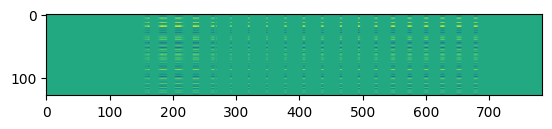

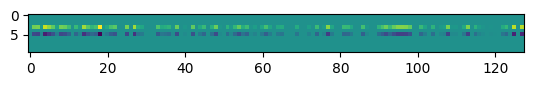

In [201]:
# backward, pytorch reference

model.zero_grad()
out = model(tensor(X_train[0:1].reshape((-1, 28*28))))
loss = F.nll_loss(out, tensor(Y_train[0:1]))
loss.backward()
plt.figure()
imshow(model.l1.weight.grad)
plt.figure()
imshow(model.l2.weight.grad)

In [214]:
# backward, ours

# dloss/dout
# out: (sample, 10)
# loss: (sample)
# basically
dout = np.zeros(out.shape)
dout[range(dout.shape[0]), Y] = -1.0

# out = log_softmax(l2)
# dout
out = F.log_softmax(tensor(forward(X_train[0].reshape(-1, 28*28)), requires_grad=True), dim=1)
loss = F.nll_loss(out, tensor(Y_test[0]))
loss.backward()
print(out.grad)


IndexError: tuple index out of range